In [1]:
from pygeoinf.interval import IntervalDomain, IntegrationConfig, Lebesgue, BoundaryConditions, Laplacian, InverseLaplacian, BesselSobolevInverse, ParallelConfig
import matplotlib.pyplot as plt
import numpy as np

# Radial Laplacian Eigenvalue Asymptotic Analysis (ℓ=0)

Testing asymptotic behavior of eigenvalues for all boundary conditions.

For large n, eigenvalues k_n (where λ_n = k_n²) should approach:
- **Case A (0,R)**: regularity-Dirichlet: k_n → nπ/R, regularity-Neumann: k_n → nπ/R
- **Case B (a,b)**: DD: k_n = nπ/L (exact), DN/ND/NN: k_n → nπ/L

In [2]:
f_dom = IntervalDomain(0, 1, boundary_type='open', open_epsilon=1e-12)
int_cfg = IntegrationConfig(method='simpson', n_points=1000)
parallel_cfg = ParallelConfig(
    enabled=True,
    n_jobs=16
)
M = Lebesgue(100, f_dom, basis='cosine', integration_config=int_cfg, parallel_config=parallel_cfg)
bcs = BoundaryConditions('neumann')

Symmetric within tol: False
||A - A.T||_inf = 1.8573690180487588e-07
min eigenvalue: -3.29689941258205e-30
max eigenvalue: 967.319927349924
is positive-definite (tol=2.15e-11): False
is positive-semidefinite: True


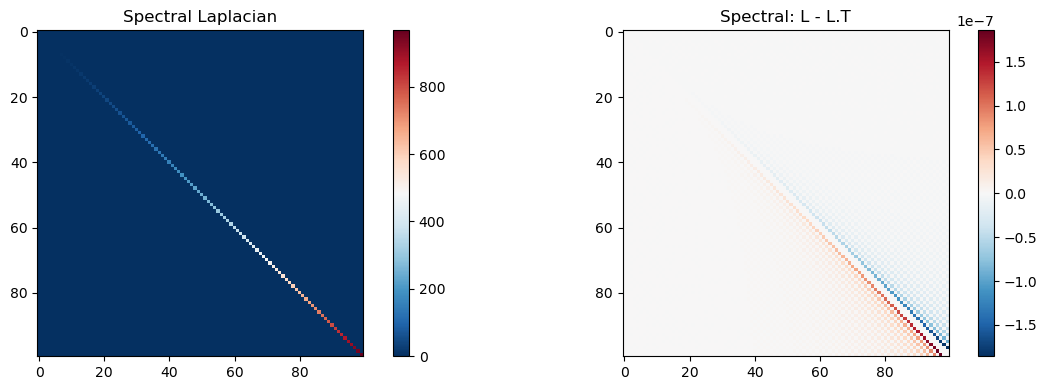

In [3]:
# Fix: Use spectral method instead of FD for spectral basis
int_cfg = IntegrationConfig(method='simpson', n_points=1000)
L_spectral = Laplacian(M, bcs, 0.1, method='spectral', dofs=100, integration_config=int_cfg)
k, s = 1, 1
C_0 = BesselSobolevInverse(M, M, k, s, L_spectral, dofs=100, n_samples=2048)
A = L_spectral.matrix(dense=True, galerkin=False, parallel=True, n_jobs=20)

# 1) Symmetry
sym = np.allclose(A, A.T, atol=1e-12, rtol=1e-8)
print("Symmetric within tol:", sym)
print("||A - A.T||_inf =", np.max(np.abs(A - A.T)))

# 2) Eigenvalues (use eigvalsh for symmetric/hermitian matrices)
eigs = np.linalg.eigvalsh(A)
print("min eigenvalue:", eigs[0])
print("max eigenvalue:", eigs[-1])

# PD test with tolerance
tol = max(A.shape) * np.finfo(float).eps * abs(eigs[-1])
is_pd = eigs[0] > tol
is_psd = eigs[0] >= -tol
print(f"is positive-definite (tol={tol:.2e}):", is_pd)
print("is positive-semidefinite:", is_psd)

# Visualize
plt.figure(figsize=(12, 4))
plt.subplot(121)
plt.imshow(A, cmap='RdBu_r')
plt.title('Spectral Laplacian')
plt.colorbar()
plt.subplot(122)
plt.imshow(A - A.T, cmap='RdBu_r')
plt.title('Spectral: L - L.T')
plt.colorbar()
plt.tight_layout()
plt.show()

/tmp/ipykernel_4101648/2867456499.py:7: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend()


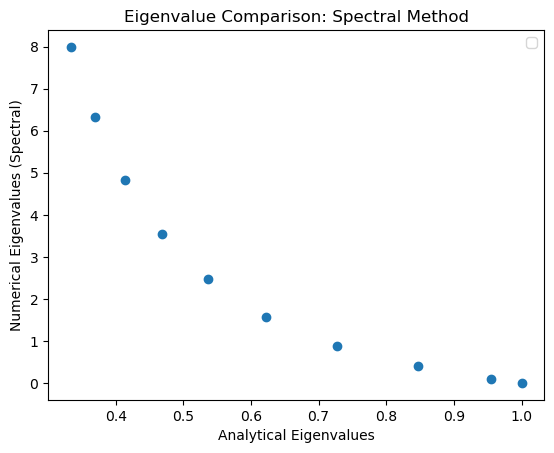

In [4]:
analytical_eigenvalues = np.array([C_0.get_eigenvalue(n) for n in range(10)])
numerical_eigenvalues_spectral = np.diag(A)[:10]
plt.scatter(analytical_eigenvalues, numerical_eigenvalues_spectral)
plt.xlabel('Analytical Eigenvalues')
plt.ylabel('Numerical Eigenvalues (Spectral)')
plt.title('Eigenvalue Comparison: Spectral Method')
plt.legend()
plt.show()